# PREDICTION OF SEVERITY OF HEMOPHILIA - A 
### Analysis of Influence of Sequence COntext in the Prediction of Severity of Hemophilia A 

In [1]:
# samyukta's dataset
import pandas as pd
dataset = 'raw_hemo_data.csv'
df = pd.read_csv(dataset)
print(df.head(n=2))

   Case ID   Type    Effect  cDNA Sequence Context  Amino acid (HGVS)  \
0      147  Point  Missense   216          GAA GAC                 72   
1       15  Point  Missense     1          ATG GTG                  1   

   Amino acid (Legacy)          Domain Locationingene  Mutation ProteinChange  \
0                   53              A1         Exon 2  c.216A>C    p.Glu72Asp   
1                  -19  Signal Peptide         Exon 1    c.1A>G     p.Met1Val   

  Comments NaturalorEngineered Severity                  Reference  \
0      NaN             Natural     Mild      Castaman et al (2009)   
1      NaN             Natural   Severe  Abdul-Ghafar et al (2010)   

  Publishing Lab  Date added  
0          Italy  10-01-2012  
1      Singapore  11-01-2012  


In [2]:
df.shape

(7784, 17)

### Data Cleaning

In [3]:
# removing redundant features, not requierd for predictions
redundant_features = ['Publishing Lab', 'Date added', 'Reference', 'Comments', 'NaturalorEngineered', 'Case ID']
df = df.drop(columns=redundant_features)

In [4]:
unique_sev = df['Severity'].unique()
print(unique_sev)
# need to fix this column - FIXED

['Mild' 'Severe' 'Severe ' 'Moderate' 'Mild ' 'Moderate ' 'severe' 'MIld']


In [5]:
# fixing the Severity column
df['Severity'] = df['Severity'].str.strip()
df['Severity'] = df['Severity'].replace('MIld', 'Mild')
df['Severity'] = df['Severity'].replace('severe', 'Severe')
severity_uni = df['Severity'].unique()
print(severity_uni)

['Mild' 'Severe' 'Moderate']


In [6]:
frequency = df['Severity'].value_counts()
print(frequency)

Severity
Severe      3391
Mild        2866
Moderate    1527
Name: count, dtype: int64


In [7]:
# Fixing Type column
df['Type'] = df['Type'].str.strip()
type_uni = df['Type'].unique()
print(type_uni)

['Point' 'Deletion' 'Duplication' 'Indel' 'Insertion']


In [8]:
# Fixing Effect column
df['Effect'] = df['Effect'].str.strip()
effect_uni = df['Effect'].unique()
print(effect_uni)

['Missense' 'Nonsense' 'Frameshift' 'Inframe' 'Splice' 'Silent'
 'Large Deletion']


### Correlogram for Type - Effect pairs

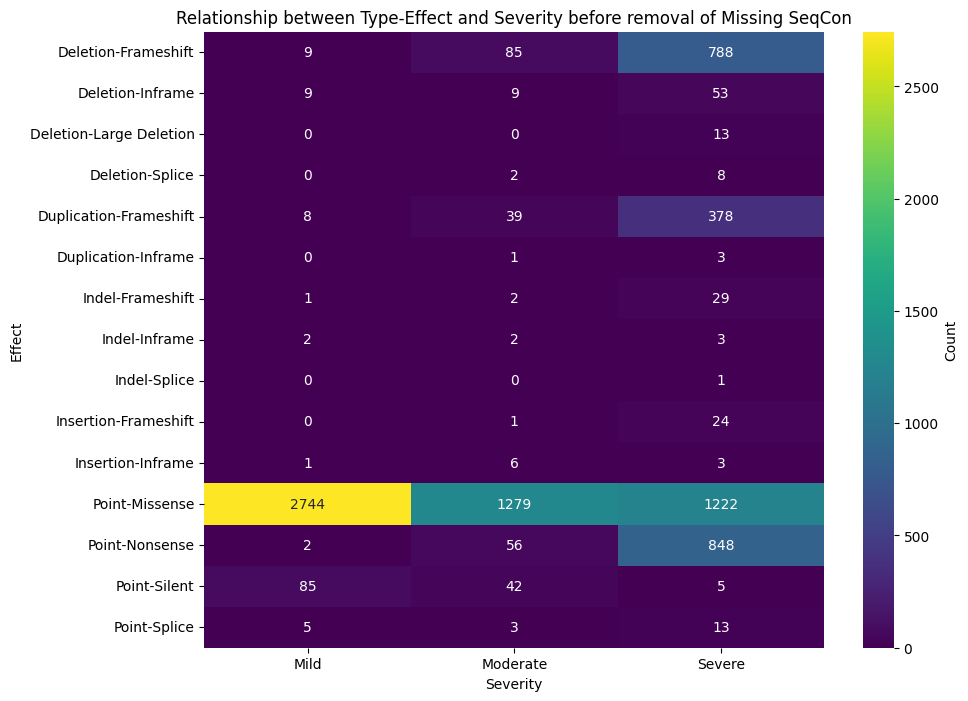

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

ty_eff_table = df.pivot_table(index=['Type', 'Effect'], columns='Severity', aggfunc='size', fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(ty_eff_table, annot=True, cmap='viridis', fmt='g', cbar_kws={'label': 'Count'})
plt.xlabel('Severity')
plt.ylabel('Effect')
plt.title('Relationship between Type-Effect and Severity before removal of Missing SeqCon')
plt.show()

In [10]:
# Fixing Domain column
effect_uni = df['Domain'].unique()
print(effect_uni)
df['Domain'] = df['Domain'].replace('a1', 'A1')
df['Domain'] = df['Domain'].replace('a2', 'A2')
df['Domain'] = df['Domain'].replace('a3', 'A3')

['A1' 'Signal Peptide' 'a1' 'A2' 'a2' 'B' 'a3' 'A3' 'C1' 'C2' nan]


In [11]:
effect_uni = df['Domain'].unique()
print(effect_uni)

['A1' 'Signal Peptide' 'A2' 'B' 'A3' 'C1' 'C2' nan]


In [12]:
missing_sequence_context = df['Sequence Context'].isna()
df.drop(df[missing_sequence_context].index, inplace=True)
print(df.shape)

(6286, 11)


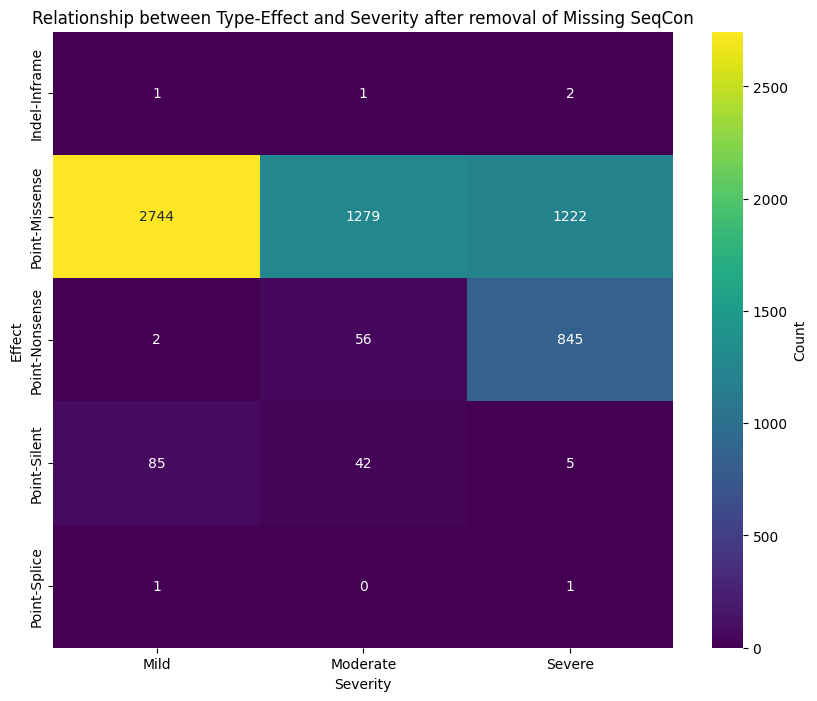

In [13]:
ty_eff_table = df.pivot_table(index=['Type', 'Effect'], columns='Severity', aggfunc='size', fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(ty_eff_table, annot=True, cmap='viridis', fmt='g', cbar_kws={'label': 'Count'})
plt.xlabel('Severity')
plt.ylabel('Effect')
plt.title('Relationship between Type-Effect and Severity after removal of Missing SeqCon')
plt.show()

In [14]:
# Splitting Sequence Context into two columns for pre-processing
df[['seqBefore', 'seqAfter']] = df['Sequence Context'].str.split(expand=True)
df.shape

(6286, 13)

In [15]:
frequency = df['Severity'].value_counts()
print(frequency)

Severity
Mild        2833
Severe      2075
Moderate    1378
Name: count, dtype: int64


### Feature Extraction 

In [16]:
# Splitting Sequence Context into before nucelotide, after nucelotide and position of replacement

def compare_sequences(row):
    before = str(row['seqBefore'])  
    after = str(row['seqAfter'])  
    nitroBaseBef = ''
    nitroBaseAft = ''
    pos = -1
    
    for i in range(0,3):
        if before[i] != after[i]:
            nitroBaseBef = before[i]
            nitroBaseAft = after[i]
            pos = i + 1
            break
            
    return pd.Series({'NitroBaseBef': nitroBaseBef,'nitroBaseAft': nitroBaseAft, 'pos': pos})

df[['nitroBaseBef','nitroBaseAft', 'pos']] = df.apply(compare_sequences, axis=1)    
print(df.head(n=3))

    Type    Effect  cDNA Sequence Context  Amino acid (HGVS)  \
0  Point  Missense   216          GAA GAC                 72   
1  Point  Missense     1          ATG GTG                  1   
2  Point  Missense     1          ATG GTG                  1   

   Amino acid (Legacy)          Domain Locationingene  Mutation ProteinChange  \
0                   53              A1         Exon 2  c.216A>C    p.Glu72Asp   
1                  -19  Signal Peptide         Exon 1    c.1A>G     p.Met1Val   
2                  -19  Signal Peptide         Exon 1    c.1A>G     p.Met1Val   

  Severity seqBefore seqAfter nitroBaseBef nitroBaseAft  pos  
0     Mild       GAA      GAC            A            C    3  
1   Severe       ATG      GTG            A            G    1  
2   Severe       ATG      GTG            A            G    1  


### Feature Extraction - 2

In [17]:
import pandas as pd

# Sample data
data = df['ProteinChange']

# Extract Original AA and New AA
df['Original AA'] = df['ProteinChange'].str.extract(r'p\.([A-Za-z]+)\d+')
df['New AA'] = df['ProteinChange'].str.extract(r'\d+([A-Za-z\*]+)')
df['New AA'] = df['New AA'].replace('*', 'Stp')

### Feature Extraction - 3

In [18]:
from Bio.Seq import Seq

def translate_sequence(sequence):
        
    seq = Seq(sequence)
    translated_seq = str(seq.translate())
    return translated_seq

df['AminoBefore'] = df['seqBefore'].apply(translate_sequence)
df['AminoAfter'] = df['seqAfter'].apply(translate_sequence)

In [19]:
df = df.drop(['Mutation', 'ProteinChange'], axis=1)

In [20]:
df.shape

(6286, 18)

In [22]:
output_path = "preprocessed_data3.csv"
df.to_csv(output_path, index=False)